# __HEART DISEASE ATTRIBUTES EXPLORATION__

## 1. Introduction
Heart disease has long been a severe cause of death worldwide. According to CDC, every 33 seconds there will be a person dying from cardiovascular disease. It can affect everyone regardless of their gender, race, and nationality. However, heart disease patients do have some common characteristics, such as smoking and obesity [1].

The question is, <i> what exactly are the attributes of heart disease nowadays? <i>

In order to address the question above, we will explore a database from UCI Machine Learning Repository, donated in 1988. It has 78 variables, but only 14 were published. The file has been roughly processed for public use. 

In this case, we will only explore the processed dataset in Hungarian, as most of its variables are in double format rather than characters, which makes it easier to use classification model later on. 

## 2. Preliminary exploratory data analysis
The database can be loaded in R normally as most of its variables are in double format. We will clean and tidy our tibble a little bit for later processing. We are also only interested in whether a person has heart disease or not, so we turn all the diseases type 1,2,3,4 in the final column (num) into the value 1 = yes, 0 = no. 


In [1]:
library (tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [109]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"

heart_hungarian <- read_csv (url, 
                             col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"), 
                             na = "?") 
heart_hungarian

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,1,2,130,132,0,2,185,0,0,NA,NA,NA,0
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,NA,NA,1
58,0,2,180,393,0,0,110,1,1,2,NA,7,1
65,1,4,130,275,0,1,115,1,1,2,NA,NA,1


In [54]:
heart_hungarian_reduced <- heart_hungarian |>  
    select (age, trestbps, thalach, oldpeak, num) |> 
    mutate (num = recode (num, "0" = "no", "1" = "yes", "2" = "yes", "3" = "yes", "4" = "yes")) |> 
    mutate (num = as.factor (num))

heart_hungarian_reduced

age,trestbps,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,130,185,0,no
29,120,160,0,no
29,140,170,0,no
⋮,⋮,⋮,⋮,⋮
56,155,150,3,yes
58,180,110,1,yes
65,130,115,1,yes


## 3. Methods

In this case, we will consider only 4 variables: age, resting blood pressure (trestbps), maximum heart rate achieved (thalach), and ST depression induced by exercise relative to rest (old peak). Firstly, these variables are numeric and do not have too many missing data. Secondly, they are important attributes of heart diseases, which can be visualized as follows:

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


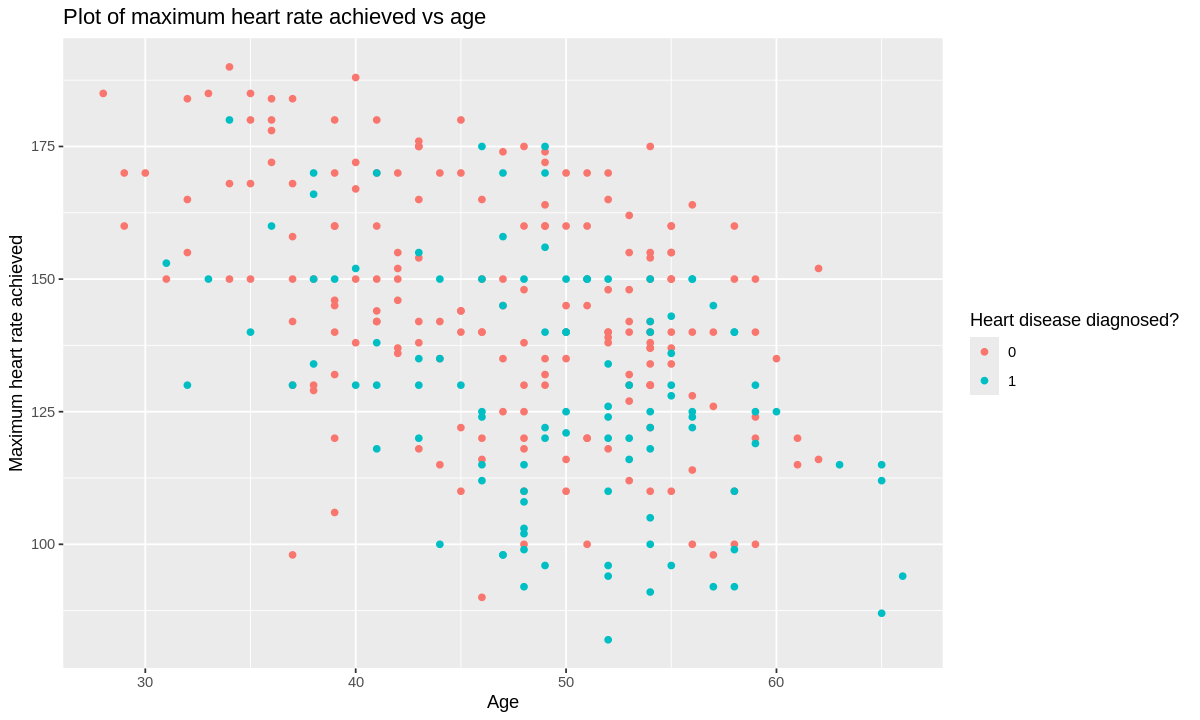

In [108]:
options (repr.plot.width = 10, repr.plot.height = 6)

heart_plot <- ggplot (heart_hungarian, aes(x=age, y = thalach, color = as.factor(num))) +
    geom_point () + 
    labs (x = "Age", y = "Maximum heart rate achieved", color = "Heart disease diagnosed?") + 
    ggtitle ("Plot of maximum heart rate achieved vs age")

heart_plot

We want to know which variable combinations would mostly affect the heart disease rate. 3 combinations have been tested using the K-nearest neighbor model. By splitting the data into training and testing sets to train the classification model, different combinations will yield different accuracies. The variable combination with the highest accuracy will have the most significant effect on heart diseases. 

For simplicity, we will consider combinations with thalach (maximum heart rate achieved), as this factor is proven to play a significant role in heart disease diagnosis [2]. 

In [66]:
set.seed (0310)

# Split the heart cleveland data into training and testing data based on ratio 3:1.
heart_split <- initial_split(heart_hungarian_reduced, prop = 0.75, strata = num)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

# Create a classification model with K = 2. 
knn_spec <- nearest_neighbor (weight_func = "rectangular", neighbors = 7) |> 
    set_engine ("kknn") |> 
    set_mode ("classification")

In [101]:
# A summarization of training data can be found below:
heart_train_summarize_1 <- heart_train |> 
    pivot_longer (cols = age:oldpeak,
                 names_to = "attributes",
                 values_to = "value") |> 
    group_by (attributes) |> 
    summarize (mean_value = mean (value, na.rm = TRUE))
    
heart_train_summarize_2 <- heart_train |> 
    group_by (num) |> 
    summarize (count = n())

heart_train_summarize_1
heart_train_summarize_2

attributes,mean_value
<chr>,<dbl>
age,47.6681818
oldpeak,0.5977273
thalach,138.9954338
trestbps,132.8675799


num,count
<fct>,<int>
no,141
yes,79


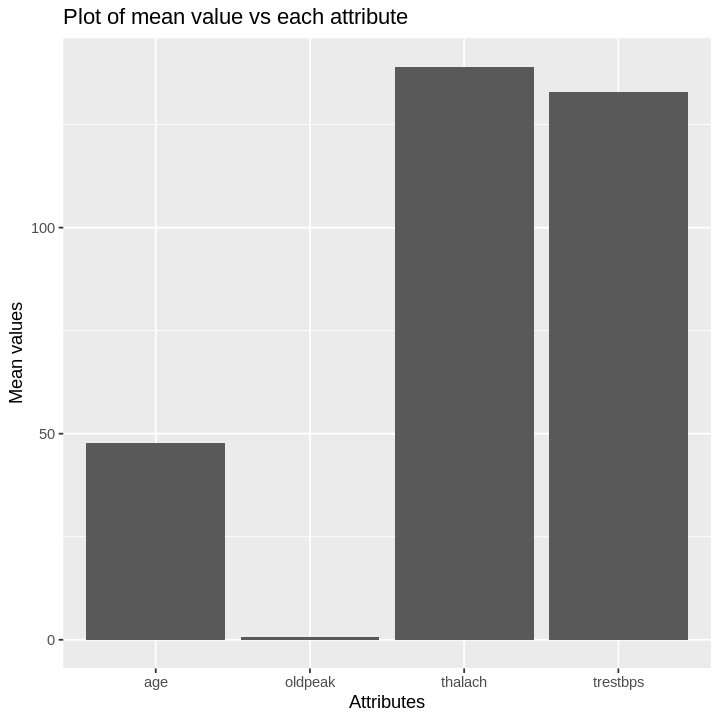

In [106]:
options (repr.plot.width = 6, repr.plot.height = 6)

attribute_plot <- ggplot (heart_train_summarize_1, aes(x=attributes, y = mean_value)) +
    geom_bar (stat = "identity") + 
    labs (x = "Attributes", y = "Mean values") + 
    ggtitle ("Plot of mean value vs each attribute")

attribute_plot

In [67]:
set.seed (2005)

# Make 3 different recipes for different variable combinations
heart_recipe <- recipe (num ~ thalach + oldpeak, data = heart_train) |> 
    step_center (all_predictors()) |> 
    step_scale (all_predictors())

heart_fit <- workflow () |> 
    add_model (knn_spec) |> 
    add_recipe (heart_recipe) |> 
    fit (data = heart_train)

heart_predict <- predict (heart_fit, heart_test)  |> 
    bind_cols (heart_test) 

heart_accuracy <- heart_predict |>
    metrics(truth = num, estimate = .pred_class) |> 
    filter(.metric == "accuracy") |>
    pull (.estimate) 

heart_predict
heart_accuracy

.pred_class,age,trestbps,thalach,oldpeak,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
no,28,130,185,0,no
no,32,105,165,0,no
no,32,110,184,0,no
⋮,⋮,⋮,⋮,⋮,⋮
yes,52,160,94,2.5,yes
no,54,130,100,0.0,yes
yes,65,130,115,1.0,yes


[1] 0.7837838

In [68]:
set.seed (2104)

heart_recipe_2 <- recipe (num ~ age + thalach, data = heart_train) |> 
    step_center (all_predictors()) |> 
    step_scale (all_predictors())

heart_fit_2 <- workflow () |> 
    add_model (knn_spec) |> 
    add_recipe (heart_recipe_2) |> 
    fit (data = heart_train)

heart_predict_2 <- predict (heart_fit_2, heart_test) |> 
    bind_cols (heart_test) 

heart_accuracy_2 <- heart_predict_2 |>
    metrics(truth = num, estimate = .pred_class) |> 
    filter(.metric == "accuracy") |>
    pull (.estimate) 

heart_predict_2
heart_accuracy_2

.pred_class,age,trestbps,thalach,oldpeak,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
no,28,130,185,0,no
no,32,105,165,0,no
no,32,110,184,0,no
⋮,⋮,⋮,⋮,⋮,⋮
yes,52,160,94,2.5,yes
yes,54,130,100,0.0,yes
no,65,130,115,1.0,yes


[1] 0.6621622

In [69]:
set.seed (310)

heart_recipe_3 <- recipe (num ~ thalach + trestbps, data = heart_train) |> 
    step_center (all_predictors()) |> 
    step_scale (all_predictors())

heart_fit_3 <- workflow () |> 
    add_model (knn_spec) |> 
    add_recipe (heart_recipe_3) |> 
    fit (data = heart_train)

heart_predict_3 <- predict (heart_fit_3, heart_test)  |> 
    bind_cols (heart_test) 

heart_accuracy_3 <- heart_predict_3 |>
    metrics(truth = num, estimate = .pred_class) |> 
    filter(.metric == "accuracy") |>
    pull (.estimate) 

heart_predict_3
heart_accuracy_3

.pred_class,age,trestbps,thalach,oldpeak,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
no,28,130,185,0,no
no,32,105,165,0,no
no,32,110,184,0,no
⋮,⋮,⋮,⋮,⋮,⋮
yes,52,160,94,2.5,yes
no,54,130,100,0.0,yes
no,65,130,115,1.0,yes


[1] 0.5945946

## 4. Expected outcomes and significance
Based on the calculations above, thalach and oldpeak combination yields the highest accuracy (0.78), which means that the maximum heart rate achieved level and ST depression induced by exercise relative to rest have significant impacts on heart disease. With these information, physicians can focus more on these aspects when diagnosing patients with potential heart diseases. 

There are several key improvements that could be made to the final project. First, we can improve the K-nearest neighbor model by tuning the K to the best-fit value and plotting the K-value graph. Secondly, variables are not bounded to maximum heart rate only, it is better to consider different variable combinations to identify the most significant factors that contribute to heart diseases. 

## Reference links:
[1]: Dipannita. A., Shanto. B., Redoy. R., Hana. S. (2022). https://doi.org/10.7759/cureus.30119

[2]: Almustafa, K.M. Prediction of heart disease and classifiers’ sensitivity analysis. BMC Bioinformatics 21, 278 (2020). https://doi.org/10.1186/s12859-020-03626-y 